In [3]:
import numpy as np 
import scipy.linalg as linalg
import matplotlib.pyplot as plt 
import qiskit
from qiskit import Aer
from qh_gates import *
from qh_circuit import QHCircuit
from tn_simu import *

In [4]:
def plot_state(amp):
    plt.figure()
    p = np.abs(amp) ** 2
    n = int(np.log2(len(amp)))
    label = [(r"{:0" + f"{n}" + r"b}").format(i) for i in range(len(amp))]
    plt.bar(label, p)
    plt.xticks(rotation=70)
    plt.title(f"{p.sum()}")
    plt.show()
    plt.close()


In [5]:
np.save('mps.npy', {})
np.save('peps.npy', {})
np.save('ibm16.npy', {})

In [6]:
def rqc(arch: TNArchitecture, ncycles, method='u', seed=None):
    from copy import deepcopy
    if seed is not None:
        np.random.seed(seed)
        
    nqubits = arch.nnodes
    qc = QHCircuit(nqubits)
    qqc = qiskit.QuantumCircuit(nqubits)

    def random_single_qubit_u(qubit):
        p1, p2, p3 = np.random.rand(3) * 2 * 0.5*np.pi
        qc.u(qubit, p1, p2, p3)
        qqc.u(p1, p2, p3, qubit)
    
    history = [0 for _ in range(nqubits)]
    def random_single_qubit_xyt(qubit):
        if history[qubit] == 0:
            qc.t(qubit)
            qqc.t(qubit)
            history[qubit] = 't' 
        elif history[qubit] == 't':
            r = np.random.randint(0, 2)
            if r == 0:
                qc.rx(qubit, 0.5*np.pi)
                qqc.rx(0.5*np.pi, qubit)
                history[qubit] = 'rx'
            elif r == 1:
                qc.ry(qubit, 0.5*np.pi)
                qqc.ry(0.5*np.pi, qubit)
                history[qubit] = 'ry'
        else:
            r = np.random.randint(0, 3)
            if r == 0:
                qc.rx(qubit, 0.5*np.pi)
                qqc.rx(0.5*np.pi, qubit)
                history[qubit] = 'rx'
            elif r == 1:
                qc.ry(qubit, 0.5*np.pi)
                qqc.ry(0.5*np.pi, qubit)  
                history[qubit] = 'ry'  
            else:
                qc.t(qubit)
                qqc.t(qubit)
                history[qubit] = 't'  

    for qubit in range(nqubits):
        if method == 'u':
            random_single_qubit_u(qubit)
        else:
            qc.h(qubit)
            qqc.h(qubit)

    for cycle in range(ncycles):
        edge_waitlist = deepcopy(arch.edges)
        while len(edge_waitlist) > 0:
            idx = np.random.randint(0, len(edge_waitlist))
            q1, q2 = edge_waitlist[idx]
            edge_waitlist = edge_waitlist[:idx] + edge_waitlist[idx+1:]

            if np.random.rand() < 0.5:
                qc.cz(q1, q2)
                qqc.cz(q1, q2)
            else:
                qc.cz(q2, q1)
                qqc.cz(q2, q1)

            if method == 'u':
                random_single_qubit_u(q1)
                random_single_qubit_u(q2)
            elif method == 'xyt':
                # random_single_qubit_xyt(q1)
                # random_single_qubit_xyt(q2)
                for q in range(qubit):
                    random_single_qubit_xyt(q) 
            else:
                raise ValueError(f"Unsupported method {method}")
    
    # for qubit in range(nqubits):
    #     qc.h(qubit)
    #     qqc.h(qubit)

    return qc, qqc



In [7]:
def rqc2(arch: TNArchitecture, depth, seed=None):
    from copy import deepcopy
    if seed is not None:
        np.random.seed(seed)
        
    nqubits = arch.nnodes
    qc = QHCircuit(nqubits)
    qqc = qiskit.QuantumCircuit(nqubits)

    edges = deepcopy(arch.edges)
    groups = []
    
    while len(edges) > 0:
        current_subset = []
        nodes_in_subset = []
        remaining_edges = []
        for edge in edges:
            u, v = edge
            if u not in nodes_in_subset and v not in nodes_in_subset:
                current_subset.append(edge)
                nodes_in_subset.append(u)
                nodes_in_subset.append(v)
            else:
                remaining_edges.append(edge)
        edges = remaining_edges

        groups.append(current_subset)
    print(len(groups))

    qubit_history = [None for _ in range(nqubits)]
    def random_single_qubit(qubit):
        r = np.random.randint(0, 2)
        if qubit_history[qubit] == None:
            qc.t(qubit)
            qqc.t(qubit)
            qubit_history[qubit] = 't' 
        elif qubit_history[qubit] == 't':
            if r == 0:
                qc.rx(qubit, 0.5*np.pi)
                qqc.rx(0.5*np.pi, qubit)
                qubit_history[qubit] = 'rx'
            else:
                qc.ry(qubit, 0.5*np.pi)
                qqc.ry(0.5*np.pi, qubit)
                qubit_history[qubit] = 'ry'
        elif qubit_history[qubit] == 'rx':
            if r == 0:
                qc.ry(qubit, 0.5*np.pi)
                qqc.ry(0.5*np.pi, qubit)  
                qubit_history[qubit] = 'ry'  
            else:
                qc.t(qubit)
                qqc.t(qubit)
                qubit_history[qubit] = 't'  
        elif qubit_history[qubit] == 'ry':
            if r == 0:
                qc.rx(qubit, 0.5*np.pi)
                qqc.rx(0.5*np.pi, qubit)  
                qubit_history[qubit] = 'rx'  
            else:
                qc.t(qubit)
                qqc.t(qubit)
                qubit_history[qubit] = 't'  
        # p1, p2, p3 = np.random.rand(3) * 2 * 0.5*np.pi
        # qc.u(qubit, p1, p2, p3)
        # qqc.u(p1, p2, p3, qubit)

    for qubit in range(nqubits):
        qc.h(qubit)
        qqc.h(qubit)


    d = 0
    this_nodes = []
    while d < depth:
        d += 1
        edges = groups[d%len(groups)]
        # CZ gate
        remaining_nodes = list(range(nqubits))
        last_nodes = this_nodes
        this_nodes = []
        for q1, q2 in edges:
            remaining_nodes.remove(q1)
            remaining_nodes.remove(q2)
            this_nodes += [q1, q2]

            if np.random.rand() < 0.5:
                qc.cz(q1, q2)
                qqc.cz(q1, q2)
            else:
                qc.cz(q2, q1)
                qqc.cz(q2, q1)

            random_single_qubit(q1)
            random_single_qubit(q2)

        # print(f"d={d}; Remain {remaining_nodes}; last {last_nodes}")
        # for qubit in remaining_nodes:
            # if qubit in last_nodes:
                # random_single_qubit(qubit)

        # for qubit in remaining_nodes:
            # random_single_qubit(qubit)
        
        # Single-qubit gate 
        # for qubit in range(nqubits):
            # random_single_qubit(qubit)

    for qubit in range(nqubits):
        qc.h(qubit)
        qqc.h(qubit) 


    return qc, qqc

In [8]:
_ = rqc2(IBM65Architecture(), 4)

4


In [13]:
arch = PEPSArchitecture(4, 4)

In [14]:
qc, qqc = rqc2(arch, 10)
qis_simulator = Aer.get_backend('statevector_simulator')


4


In [25]:
qis_qc_transpiled = qiskit.transpile(qqc, qis_simulator)
ssv = qis_simulator.run(qis_qc_transpiled).result().get_statevector().data
ssv /= np.linalg.norm(ssv)
probs = np.abs(ssv) ** 2
# probs = probs[np.random.randint(0, len(probs), 1000)]

In [26]:
N = 2 ** arch.nnodes
np.sum(-probs * np.log(N*np.exp(-N*probs)))

-8.840023964100236

In [27]:
def get_distribution_statistis(probs):
    N = len(probs)
    m1 = np.log(np.mean(probs))
    m2 = np.log(np.mean(probs**2))
    m3 = np.log(np.mean(probs**3))
    m4 = np.log(np.mean(probs**4))
    probs_non_zero = probs[probs != 0]
    entropy = -(probs_non_zero * np.log(probs_non_zero)).sum()

    # H0 = np.log(N) - 1 + 0.5772156649

    # m1e = 1 / N
    # m2e = 2 / N**2
    # m3e = 6 / N**3
    # m4e = 24 / N**4
    # print(f'1st moment: {m1}; Expected {m1e}')
    # print(f'2nd moment: {m2}; Expected {m2e}')
    # print(f'3rd moment: {m3}; Expected {m3e}')
    # print(f'4th moment: {m4}; Expected {m4e}')
    return np.array([m1, m2, m3, m4, entropy])

### Verification of Porter-Thomas Distribution

In [28]:
N = 2**16
np.log(1 / N), np.log(2 / N**2), np.log(6 / N**3), np.log(24 / N**4), np.log(N) - 1 + 0.5772156649

(-11.090354888959125,
 -21.487562597358306,
 -31.479305197649317,
 -41.18336572548855,
 10.667570553859125)

#### MPS

In [29]:
mps_arch = MPSArchitecture(16)
qis_simulator = Aer.get_backend('statevector_simulator')
mps_dict = np.load('mps.npy', allow_pickle=True).item()

In [30]:
for depth in range(2, 41, 2):
    stats = np.zeros((10, 5))
    for i in range(10):
        _, mps_qis_qc = rqc2(mps_arch, depth, seed=None)
        qis_qc_transpiled = qiskit.transpile(mps_qis_qc, qis_simulator)
        ssv = qis_simulator.run(qis_qc_transpiled).result().get_statevector().data
        ssv /= np.linalg.norm(ssv)
        probs = np.abs(ssv) ** 2
        stats[i,:] = get_distribution_statistis(probs)
    print(f"Depth {depth}; stats {stats.mean(axis=0)}")
    mps_dict[depth] = stats 
    np.save('mps.npy', mps_dict)


Depth 2; stats [-11.09035489 -20.63723456 -29.70450151 -38.62246738  10.05280532]
Depth 4; stats [-11.09035489 -21.3340117  -31.14665379 -40.71423227  10.56447694]
Depth 6; stats [-11.09035489 -21.2050586  -30.77415982 -39.98874441  10.4926091 ]
Depth 8; stats [-11.09035489 -21.14090922 -30.57480442 -39.61059726  10.46914032]
Depth 10; stats [-11.09035489 -21.24318077 -30.80503707 -39.94479538  10.5358526 ]
Depth 12; stats [-11.09035489 -21.28431249 -30.91215258 -40.12591927  10.55776578]
Depth 14; stats [-11.09035489 -21.34783535 -31.07958384 -40.42507115  10.59468393]
Depth 16; stats [-11.09035489 -21.38553992 -31.18566844 -40.62497582  10.61492399]
Depth 18; stats [-11.09035489 -21.41270819 -31.25969304 -40.75147016  10.62932161]
Depth 20; stats [-11.09035489 -21.4574894  -31.38923561 -41.00105433  10.65221488]
Depth 22; stats [-11.09035489 -21.46363982 -31.40746282 -41.03990965  10.65560229]
Depth 24; stats [-11.09035489 -21.46839478 -31.42174859 -41.0653604   10.6577282 ]
Depth 26

#### PEPS

In [31]:
peps_arch = PEPSArchitecture(4,4)
qis_simulator = Aer.get_backend('statevector_simulator')
peps_dict = np.load('peps.npy', allow_pickle=True).item()

In [32]:
for depth in range(2, 41, 2):
    stats = np.zeros((10, 5))
    for i in range(10):
        _, peps_qis_qc = rqc2(peps_arch, depth, seed=None)
        qis_qc_transpiled = qiskit.transpile(peps_qis_qc, qis_simulator)
        ssv = qis_simulator.run(qis_qc_transpiled).result().get_statevector().data
        ssv /= np.linalg.norm(ssv)
        probs = np.abs(ssv) ** 2
        stats[i,:] = get_distribution_statistis(probs)
    print(f"Depth {depth}; stats {stats.mean(axis=0)}")
    peps_dict[depth] = stats 
    np.save('peps.npy', peps_dict)


Depth 2; stats [-11.09035489 -20.19450065 -28.65134941 -36.88889644   9.76143434]
Depth 4; stats [-11.09035489 -21.20131871 -30.86292878 -40.26115485  10.45357802]
Depth 6; stats [-11.09035489 -21.4382331  -31.36298155 -41.00277211  10.63657172]
Depth 8; stats [-11.09035489 -21.44402868 -31.36979112 -41.00343397  10.64226488]
Depth 10; stats [-11.09035489 -21.47989974 -31.45777313 -41.14487663  10.66375488]
Depth 12; stats [-11.09035489 -21.4864113  -31.4771916  -41.18251719  10.66682396]
Depth 14; stats [-11.09035489 -21.48689731 -31.47529123 -41.16963711  10.66748131]
Depth 16; stats [-11.09035489 -21.48661855 -31.47407101 -41.16723425  10.66758077]
Depth 18; stats [-11.09035489 -21.48623204 -31.47488961 -41.17412719  10.66687267]
Depth 20; stats [-11.09035489 -21.48827643 -31.48303392 -41.19326259  10.66761474]
Depth 22; stats [-11.09035489 -21.48586234 -31.47380406 -41.17194528  10.6667758 ]
Depth 24; stats [-11.09035489 -21.48914428 -31.48288316 -41.19077399  10.66880684]
Depth 26

#### IBM16

In [33]:
ibm16_arch = IBM16Architecture()
qis_simulator = Aer.get_backend('statevector_simulator')
ibm16_dict = np.load('ibm16.npy', allow_pickle=True).item()

In [34]:
for depth in range(2, 41, 2):
    stats = np.zeros((10, 5))
    for i in range(10):
        _, ibm16_qis_qc = rqc2(ibm16_arch, depth, seed=None)
        qis_qc_transpiled = qiskit.transpile(ibm16_qis_qc, qis_simulator)
        ssv = qis_simulator.run(qis_qc_transpiled).result().get_statevector().data
        ssv /= np.linalg.norm(ssv)
        probs = np.abs(ssv) ** 2
        stats[i,:] = get_distribution_statistis(probs)
    print(f"Depth {depth}; stats {stats.mean(axis=0)}")
    ibm16_dict[depth] = stats 
    np.save('ibm16.npy', ibm16_dict)


Depth 2; stats [-11.09035489 -18.80597804 -25.69273699 -32.32253669   8.59439079]
Depth 4; stats [-11.09035489 -20.60832578 -29.507212   -38.11478953  10.04607495]
Depth 6; stats [-11.09035489 -21.37137055 -31.20849912 -40.77984089  10.59726748]
Depth 8; stats [-11.09035489 -21.15899292 -30.61626551 -39.67745764  10.48240931]
Depth 10; stats [-11.09035489 -21.39988437 -31.24229586 -40.75658622  10.61929497]
Depth 12; stats [-11.09035489 -21.44290136 -31.36060263 -40.9751015   10.6427839 ]
Depth 14; stats [-11.09035489 -21.47084032 -31.42730978 -41.07632888  10.65964533]
Depth 16; stats [-11.09035489 -21.47770411 -31.4517888  -41.134775    10.66258767]
Depth 18; stats [-11.09035489 -21.47994433 -31.456861   -41.13852191  10.66351885]
Depth 20; stats [-11.09035489 -21.4856655  -31.47336564 -41.17098379  10.66673462]
Depth 22; stats [-11.09035489 -21.48664746 -31.47730558 -41.18071871  10.66691984]
Depth 24; stats [-11.09035489 -21.48490065 -31.46993794 -41.1623597   10.66638615]
Depth 26

#### Plots


In [37]:
arch = PEPSArchitecture(4,4)
qis_simulator = Aer.get_backend('statevector_simulator')


In [63]:
_, peps_qis_qc = rqc2(arch, 10, seed=None)
qis_qc_transpiled = qiskit.transpile(peps_qis_qc, qis_simulator)
ssv = qis_simulator.run(qis_qc_transpiled).result().get_statevector().data
ssv /= np.linalg.norm(ssv)
probs = np.abs(ssv) ** 2



In [64]:
count, divide = np.histogram(probs, bins=100, density=True)
divide = (divide[1:] + divide[:-1]) / 2

In [92]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


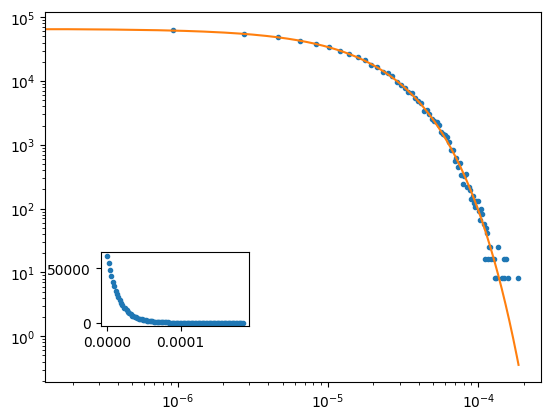

In [102]:
fig, ax = plt.subplots()

ax.plot(divide, count, '.')

N = 2 ** arch.nnodes
p = np.linspace(0, probs.max(), 1000)
y = N * np.exp(-N*p)

ax.plot(p, y)

ax.loglog()

ax1 = inset_axes(ax, width='30%', height='20%', loc='lower left', borderpad=4) 
ax1.plot(divide, count, '.')


In [157]:
import matplotlib.pylab as pylab
pylab.rcParams.update({
    'legend.fontsize': 'large',
    'axes.labelsize': 'large',
    'axes.titlesize': 'large',
    'xtick.labelsize': 'large',
    'ytick.labelsize': 'large',
})

In [158]:
mps_h1 = np.load('mps_xyt_h.npy', allow_pickle=True).item()
mps_h0 = np.load('mps_xyt_no_h.npy', allow_pickle=True).item()
peps_h1 = np.load('peps_xyt_h.npy', allow_pickle=True).item()
peps_h0 = np.load('peps_xyt_no_h.npy', allow_pickle=True).item()
ibm16_h1 = np.load('ibm16_xyt_h.npy', allow_pickle=True).item()
ibm16_h0 = np.load('ibm16_xyt_no_h.npy', allow_pickle=True).item()

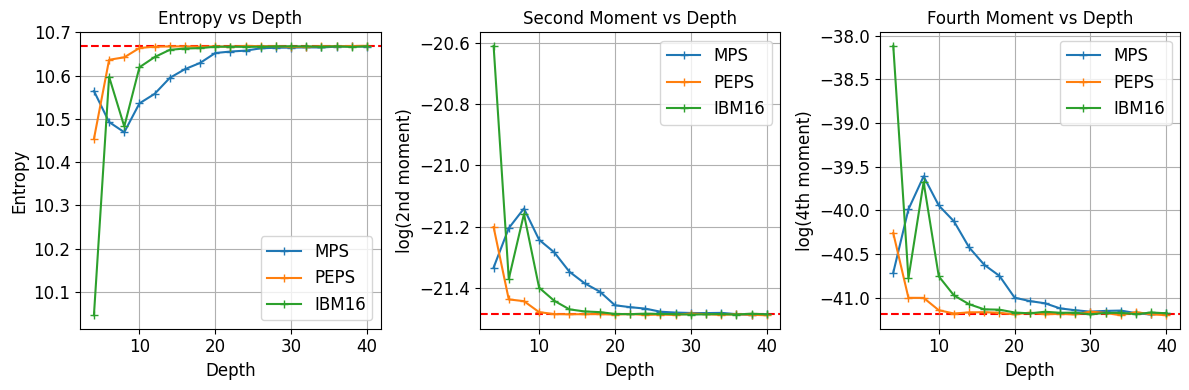

In [167]:
keys = list(range(4, 41, 2))
fig, axs = plt.subplots(ncols=3, figsize=(12,4))
mps_h1_mean = np.array([mps_h1[key].mean(axis=0) for key in keys]).T
mps_h1_std = np.array([mps_h1[key].std(axis=0) for key in keys]).T
peps_h1_mean = np.array([peps_h1[key].mean(axis=0) for key in keys]).T
peps_h1_std = np.array([peps_h1[key].std(axis=0) for key in keys]).T
ibm16_h1_mean = np.array([ibm16_h1[key].mean(axis=0) for key in keys]).T
ibm16_h1_std = np.array([ibm16_h1[key].std(axis=0) for key in keys]).T

axs[0].axhline(10.667570553859125, linestyle='dashed', color='red')
axs[0].plot(keys, mps_h1_mean[4], '+-', label='MPS')
axs[0].plot(keys, peps_h1_mean[4], '+-', label='PEPS')
axs[0].plot(keys, ibm16_h1_mean[4], '+-', label='IBM16')
axs[0].set_xlabel('Depth')
axs[0].set_ylabel('Entropy')
axs[0].legend()
axs[0].set_title("Entropy vs Depth")

axs[1].axhline(-21.487562597358306, linestyle='dashed', color='red')
axs[1].plot(keys, mps_h1_mean[1], '+-', label='MPS')
axs[1].plot(keys, peps_h1_mean[1], '+-', label='PEPS')
axs[1].plot(keys, ibm16_h1_mean[1], '+-', label='IBM16')
axs[1].set_xlabel('Depth')
axs[1].set_ylabel('log(2nd moment)')
axs[1].legend()
axs[1].set_title("Second Moment vs Depth")

axs[2].axhline(-41.18336572548855, linestyle='dashed', color='red')
axs[2].plot(keys, mps_h1_mean[3], '+-', label='MPS')
axs[2].plot(keys, peps_h1_mean[3], '+-', label='PEPS')
axs[2].plot(keys, ibm16_h1_mean[3], '+-', label='IBM16')
axs[2].set_xlabel('Depth')
axs[2].set_ylabel('log(4th moment)')
axs[2].legend()
axs[2].set_title("Fourth Moment vs Depth")

axs[0].grid()
axs[1].grid()
axs[2].grid()


plt.tight_layout()

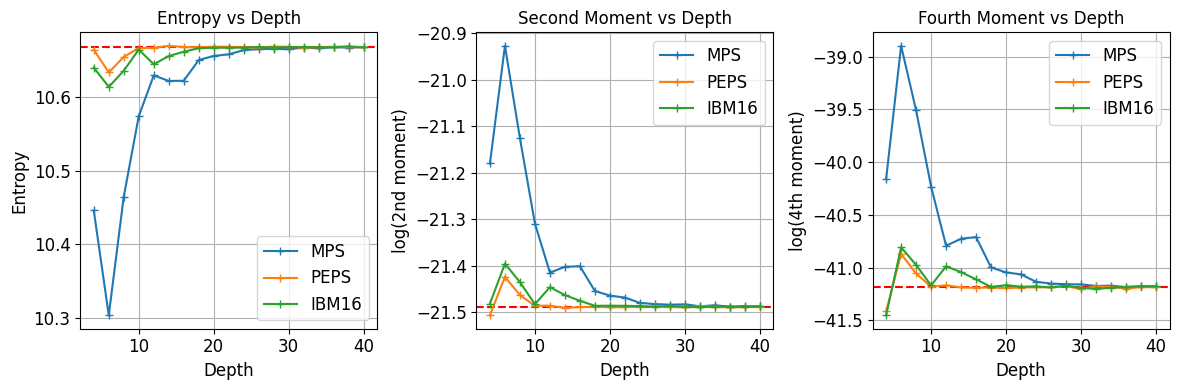

In [169]:
keys = list(range(4, 41, 2))
fig, axs = plt.subplots(ncols=3, figsize=(12,4))
mps_h1_mean = np.array([mps_h0[key].mean(axis=0) for key in keys]).T
mps_h1_std = np.array([mps_h0[key].std(axis=0) for key in keys]).T
peps_h1_mean = np.array([peps_h0[key].mean(axis=0) for key in keys]).T
peps_h1_std = np.array([peps_h0[key].std(axis=0) for key in keys]).T
ibm16_h1_mean = np.array([ibm16_h0[key].mean(axis=0) for key in keys]).T
ibm16_h1_std = np.array([ibm16_h0[key].std(axis=0) for key in keys]).T

axs[0].axhline(10.667570553859125, linestyle='dashed', color='red')
axs[0].plot(keys, mps_h1_mean[4], '+-', label='MPS')
axs[0].plot(keys, peps_h1_mean[4], '+-', label='PEPS')
axs[0].plot(keys, ibm16_h1_mean[4], '+-', label='IBM16')
axs[0].set_xlabel('Depth')
axs[0].set_ylabel('Entropy')
axs[0].legend()
axs[0].set_title("Entropy vs Depth")

axs[1].axhline(-21.487562597358306, linestyle='dashed', color='red')
axs[1].plot(keys, mps_h1_mean[1], '+-', label='MPS')
axs[1].plot(keys, peps_h1_mean[1], '+-', label='PEPS')
axs[1].plot(keys, ibm16_h1_mean[1], '+-', label='IBM16')
axs[1].set_xlabel('Depth')
axs[1].set_ylabel('log(2nd moment)')
axs[1].legend()
axs[1].set_title("Second Moment vs Depth")

axs[2].axhline(-41.18336572548855, linestyle='dashed', color='red')
axs[2].plot(keys, mps_h1_mean[3], '+-', label='MPS')
axs[2].plot(keys, peps_h1_mean[3], '+-', label='PEPS')
axs[2].plot(keys, ibm16_h1_mean[3], '+-', label='IBM16')
axs[2].set_xlabel('Depth')
axs[2].set_ylabel('log(4th moment)')
axs[2].legend()
axs[2].set_title("Fourth Moment vs Depth")

axs[0].grid()
axs[1].grid()
axs[2].grid()


plt.tight_layout()